In [10]:
from __future__ import annotations
from jackpot.algorithms.metropolis_hastings import metropolis_hastings_accept
from jackpot.primitives.utils import temp_to_beta
import seaborn as sns
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from typing import Self
from jackpot.state import State
from jackpot.typing import RNGKey

from jaxtyping import Bool, Array, UInt
from jax import lax
from jax import random
import jax.numpy as jnp
import equinox as eqx
from jackpot.models.ising import IsingModel
from jackpot.utils.graph import show
from jackpot.utils.random import EasyKey
from jackpot.algorithms.glauber import GlauberAlgorithm
import jax.config
import os
from jackpot.algorithms.cluster import ClusterAlgorithm
from jackpot.primitives.local import get_random_point_idx
from jackpot.primitives.state import get_trial_spin

# Force usage of CPU in this notebook only
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_platforms", "cpu")

# CPU cores as separate devices
os.environ[
    "XLA_FLAGS"
] = f"--xla_force_host_platform_device_count={os.cpu_count()}"


# Jackpot – a highly scalable, generalised Potts Model simulator

Submitted: 2023-05-01

## Introduction
The understanding of phase transitions in physical systems is often aided simulations of _lattice models_, with perhaps the most famous example being the revered _Ising Model_,
which is often formulated as a two-dimensional square lattice of of _spins_ that may adopt
one of two states ${-1, 1}$. Remarkably, when neighbouring spins on the lattice are taken to
interact with a coupling strength $J$ and the system is evolved in a manner that satisfies the principle of _detailed balance_, a phase transition be observed at a critical point as defined by an independent parameter of the system, which will be the inverse temperature $β ≡ \frac{1}{k_B T}$ when working with Boltzmann distributions.

The Ising Model is further generalised by the _Potts Model_, which again may be generalised into the _$N$-Vector Model_, which also encapsulates the _Heisenberg Model_ and _XY Model_, all of which are important models in statistical mechanics and condensed matter physics, though they occassionally find also find uses in network theory and quantitative sociology (van der Maas et al., 2020).

Evolving a system such that it reaches an equilibrium position and subsequently sampling different uncorrelated states of the equilibrated system proves to be a very computationally intensive process. A variety of different algorithms exist that obey the detailed balance criterion while trying to propagate and sample the model states as efficiently as possible, where a notable example of a _local algorithm_ is the famous _Metropolis-Hastings algorithm_, though it is often preferable to for larger lattice sizes to work with a _cluster algorithm_ that is able to change multiple lattice sites per iteration, with the _Wolff algorithm_ being a common choice.

_Jackpot_ is a framework for working with a variety of different lattice models and algorithms in a highly scalable manner and makes use of the XLA (_Accelerated Linear Algebra_, (XLA, Google, n.d.)) compiler from Google in order to target fast and energy-efficient accelerator hardware such as NVIDIA GPU's and Google TPU's (_Tensor Processing Units_, (TPU, Google, n.d.)) in addition to traditional CPU-based execution.

## A Reader's Guide

Due to a rather debilitating inability to contain my enthusiasm for both computer science and physics, the combination of these two areas in a single report in addition the somewhat more relaxed formal requirements of the report, the project has grown to include a study into scalability of computational physics. This was aided and abetted by an extraordinarily generous grant of computing time on Google's TPU Research Cloud.

The reports starts out with a brief discussion of the physics we are trying to simulate – while all key concepts and formulae are reproduced in the report, their derivations are omitted benefit of the impatient reader, who may benefit by subsequently perusing the cited publications in any areas that may remain unclear.

Following the physical foundation, the challenges of scaling scientific computing problems is briefly discussed and the constraints imposed by solving these using the JAX framework are presented. This material is expected to be unfamiliar to the reader and the unique implications of using JAX are important in understanding the design decisions covered in the presentation of the implementation.

As the reader progresses through the report, they will be met with an increasing density of of code, though they may wish to supplement this by referring to the Python code located in the `jackpot/` folder, which is heavily laden with comments and _docstrings_.

## Theory - Physics

### A Brief Introduction to Lattice Models
While this project is primarily focused on the computational approaches to working with lattice models and how to best solve the problems around scaling them, it is important to have a thorough understanding of the physical behaviour of the system we are trying to simulate. A very thorough description of the Ising Model is given in the the somewhat ironically named publication "_A Brief Account of the Ising and Ising-like Models_" by Jozef Strečka and Michal Jaščur (Strecka and Jaščur, 2015), though much of this is concerned with the more analytically tractable _mean field_ approaches to solving the Ising Model, whereas we wish to explore the _exact field_ version of the model by leveraging our computational implementation.

While the Ising Model is most commonly studied in two dimensions, we will do away with this constraint and develop our understanding using an arbitrary number of dimensions, drawing examples from a two-dimensional system where these may benefit our understanding.

Having lifted the constraint of two dimensions, we can further generalise the Ising Model by instead moving to the _Potts Model_ where we no longer limit the number of possible spin states to just two, but rather $q$ different discrete spin states. 

Additionally, we can introduce more interaction parameters such as an external interacting field that encourages spins to align in a particular spin state over another or we can have interaction effects that go beyond merely the nearest neighbour on the lattice, which itself does not have to be hypercubic, but may take any crystal lattice structure and adopt an arbitrarily complex _motif_.

While we may wish to allow for all of these generalisations and more in our framework, we
will restrict ourselves to models on hypercubic lattices with one a site in the motif. _Jackpot_ is written in a way where these generalisations can be lifted, though not as easily and interchangibly as changing the model or evolution algorithm.

#### An Aside on the Generality of Lattice Models
The description of lattice models above is heavily tinted by the physical framework within which lattice models often find their application. For example, one might want to avoid referring to the spin states as just that and instead adopt the more general terminology of lattice site states if investigating the model outside of a physical perspective, though we are physicists and will allow our familiar terminology here.

Indulge me as we venture away from the physical part of physics and instead apply our
physical intuition to another important dynamic system: society.

It is worthwhile keeping in mind that these models do have uses outside of physics and every physical, thermodynamic phenomenon must therefore, interestingly, have an equivalent quantity in whatever domain the model is applied to. For example, if the Ising Model is applied to party political affiliation along an axis mapping the wealth distributive policy of a system, one might adopt the public's political engagement as the temperature-like variable and find that systems with lower democratic activity will equilibrate into either a capitalist "phase" or a socialist "phase" below a critical point. This is analogous to how the magnetisation density is bifurcated below the critical temperature in the physical Ising Model – political systems tend to be somewhat more dynamic and harder to make fit into quantitative models than physical systems, though anecdotally the American two-party system does seem to be "too cold" to exist in a single phase – one might wonder what intensive variable might be tuned to overcome the the phenomenon of political polarisation – Perhaps the Information Age has lead to an increase in the linear interaction parameter $J$, which would in turn increase the critical "temperature" $T_c$ needed to prevent precipitation.

Be warned: when you allow yourself to observe physics outside the traditional domain of the discipline, its models start cropping up in the most peculiar places. 

As we recover from the frightful prospect of having briefly turned into _social scientists_ – two terms that normally exist in separate phases when interpreted either as a behavioural statement or a disciplinary description – we quickly return to the familiar embrace of the mathematical framework of statistical physics.

While a full regurgitation is beyond the scope of this report, we will introduce our lattice models in some detail here, starting with the Ising Model

### The Ising Model

We construct a an array of size $L^D$ that represents a trunctated hypercubic lattice with each element of the array representing a single lattice site, indexed by $i$, which may adopt values $s_i ∈ {±0.5}$ (note that this is sometimes taken to be ${±1}$ in the literature, which leads to a factor $2$ difference in the critical temperature value). Conceptually it is helpful to arrange our array as an ND-array – that is, an array of $D$ axes, in which case our indexing variable $i$ becomes a set of numbers that uniquely index each site.

We can then give a geometrical meaning to our array and index by declaring that indices that vary by $±1$ along a single axis are said to be _neighbours_ – in the most general case these would be connected vertices on an arbitrary graph. It now becomes difficult not to imagine our array as an $D$-dimensional primitive hypercubic crystal, which is indeed a helpful picture to keep in mind. We will impose periodic boundary conditions by tweaking the indices as neccessary to cause the crystal to _wrap around_ itself which helps mitigate the edge effects of our truncated model. Note that due to the correlation of the spins on the lattice reaching beyond the size of the truncated model in many cases, periodic boundary conditions are not a perfect fix. In fact, it is an interesting problem in its own right to observe how the point of criticality scales with the lattice size as we shall see.

Next we want to introduce an interaction Hamiltonian that describes how the energy of our system arises as a function of the spins and their interactions with their neighbours. For the Ising Model a generalised interaction Hamiltonian could look like (Taheridehkordi and Zivieri, 2020):

$$
𝒣(s) =
-\sum_{<ij>} J_{ij} s_i s_j
-\sum_{<ij>} K_{ij} s_i^2 s_j^2
-\sum_{i=0}^{L^D - 1} D_i s_i^2
-\sum_{<ij>} L_{ij} (s_i^2 s_j + s_i s_j^2)
-\sum_{i=0}^{L^D - 1} μ_i H_i s_i
$$

Where $<ij>$ sums over neighbouring sites only and $i,j$ are taken to the the "flat" indices of our array – that is, for the purposes of the definition above, the geometrical structure of the array has been moved from the indexing variable to the $<ij>$ operation. Note that varying definitions of $<ij>$ and whether to "double count" generally leads to another factor $2$ difference in the numerical value of the critical temperature, $T_c$.

The coefficients are given the following names:
- $J$: Linear Interaction Coefficient
- $K$: Biquadratic Interaction Coefficient
- $D$: Anisotropy Coefficient
- $L$: Bicubic Interaction Coefficient
- $μ$: Nuclear Magnetic Moment
- $H$: External Magnetic Field Strength

Often the many of these parameters are set to $1$ or $0$, and it is common to find $K = D = L = 0$ and $J = μH = 1$ in papers that explore more exotic interactions. Additionally, it is often assumed that the coefficients are independent of the lattice sites such that $J_{ij} = J$, for example.

### Statistical and Thermodynamic Foundation
The _configuration probability_ $P(s, β)$ of the system then follows a Boltzmann Distribution:

$$
P(s, β) = \frac{e^{-β𝒣(s)}}{\sum_{s} e^{-β𝒣(s)}}
$$

Interestingly, we are already able to determine thermodynamic quantities about a given state $s$ by recognizing the partition function in the denominator of the configuration probability:

$$
Z(s, β) = \sum_{s} e^{-β𝒣(s)}
$$

From which we can recover the magnetisation density $M$ as (Taheridehkordi and Zivieri, 2020):

$$
m(s) = \frac{1}{L^D} \sum_{i=0}^{L^D -1} s_i
$$

Further, using the _fluctuation-dissipation theorem_ and our knowledge of statistical physics, we can recover expressions for the specific heat capacity $C$ and the _initial_ magnetic susceptibility $χ$ for systems where the external magnetic field interaction is off, $H_i = 0$ (Strecka and Jaščur, 2015)(Taheridehkordi and Zivieri, 2020):

$$
C(s, β)
= \frac{\langle 𝒣(s)^2 \rangle - \langle 𝒣(s) \rangle^2}{k_B T^2}
= \frac{∂𝒣(s)}{∂T}
$$

$$
χ(s, β, H=0)
= β L^D \left(\langle m(s)^2 \rangle - \langle m(s) \rangle^2\right)
= L^D \left| \frac{∂m(s)}{∂T}\right|
$$

Recalling that:
$$
β ≡ \frac{1}{k_B T}
$$

#### Correlation Length and Critical Phenomena

It will be instructive to introduce a _correlation length_, $ξ$, which describes the characteristic length with which spins on the lattice are correlated (Timothy Budd, n.d.). The magnitude of this length are particularly interesting when applied to our computational model, as they are observed to diverge as the temperature approaches criticality around $T_c$:

$$
ξ ∼ \left| T - T_c \right|^{-ν} 
$$

Where $ν$ is said to be the _critical exponent_ of the correlation length $ξ$, with $T_c$ being the critical point where the phase transition is observed. In fact, we are able to find _critical exponents_ associated with all of the thermodynamic quantities defined above (Lundow and Campbell, 2018):

| Thermodynamic Quantity  | Quantity Symbol | Critical Exponent |
| ----------------------- | :-------------: | :---------------: |
| Specific Heat Capacity  | $C$             | $α$                |
| Magnetisation Density   | $m$             | $β$ (here taken to be $B$ to avoid confusion with inverse temperature) | 
| Magnetic Susceptibility | $χ$             | $γ$                |
| Correlation Length      | $ξ$             | $ν$                |

Notably the thermodynamic quantities are only expected to go to their infinite limit in the case of an infinite sized lattice, but nonetheless observed to diverge for finite lattice sizes. 

### Determination of the Point of Criticality

Additionally, we find that the critical temperature, $T_c(L)$, of the system to be dependent on the lattice size, but may wish to find the true critical temperature, $T_c(∞)$, for a system with an infinite lattice size. This may be achieved by introducing the second and fourth order Binder Cumulants (Selke, 2006), whose crossings when observed for different lattice sizes reveals the location of $T_c(∞)$. While different formulations exist, we choose to define the cumulants as:

$$
U_2(s) ≡ 1 - \frac{\langle m(s)^2 \rangle}{\left[\langle \left |m(s) \right| \rangle\right]^2}
$$

$$
U_4(s) ≡ \frac{1}{3} - \frac{\langle m(s)^4 \rangle}{3 \left[\langle m^2(s) \rangle\right]^2}
$$

## Theory - Computational

While computation is a significant part of most branches of physics, advances in hardware and software design enable us to improve our understanding of physics through increasingly large and complex simulations of physical systems. While this project is focused on the Ising Model and simulations of the Ising Model, this is largely used example of why computational physics is important, what makes it difficult, and how simulations can be scaled. 

### Achieving Computational Efficiency and Scalability

It is often possible to write an algorithm in a conceptually simple manner by using intuition and computational primitives like loops alone. A popular choice within scientific circles is Python and its extensive suite of scientifically oriented libraries with notable examples being `numpy`, `SciPy`, and `pandas`.

Being a fully interpretted language, as opposed to a compiled language or just-in-time compiled language (note that JIT implementations of Python do exist and the main Python implementation, CPython, is currently taking steps towards implementing JIT specialisation techniques), Python is often criticised for being hopelessly slow.

This is mitigated somewhat by implementing numerically intense functionality in compiled languages – often C, C++ or FORTRAN – "under the hood" and calling these from Python. These libraries are able to use principles like _vectorisation_ and _parallelisation_, allowing several computations to be performed in a single CPU cycle or across multiple CPU cores respectively.

An additional technique that is becoming increasingly common is leveraging specialised hardware that is able to perform specific operations much more quickly (and power-efficiently) than CPU's, though implementing algorithms that target specialised hardware is often difficult and generally requires compilation targetting the architecture in question. For example, very few machine learning applications will target traditional CPU's, which are largely replaced by GPU's and, more exotically, TPU's.

In summary, we may implement some of the following techniques in order to improve the computational efficiency of our algorithm:
- Vectorisation — compute multiple values at the same time on a single core
- Parallelisation — split computation across multiple cores
- Target accelerators (GPU, TPU) – compute on devices that specialise in certain operations
- Use compiled software that can implement tricks and hardware specialisations




### Monte-Carlo Simulations

While introducing the topic of Monte-Carlo simulations with the appropriate level of rigour would instructive, it falls outside the scope of this report. Instead, we recall that they are probabilistic models that work by sampling many possible states of an outcome and in doing so producing an estimate of a value.

For our model, it becomes crucial to find an algorithm that allows us to explore different, _uncorrelated_ states, $s$, in an efficient manner while obeying the _detailed balance condition_:

$$
P_{jk} π_k = π_j P_{kj}
$$

Where $π_j$ denotes an equilibrium configuration $j$ and $P_{kj}$ denotes a probability of transferring into this configuration from a different equilibrium configuration $k$. As such, our detailed balance condition simply states that our transitions are equally likely to go in either direction at equilibrium.


### Lattice Algorithms

In order to do to Monte-Carlo Simulations, we need a way to obtain different samples (or configurations, depending on your terminology of choice) of the system quickly. Crucially, these need to _uncorrelated_. As discussed in the section covering the physical theory, the _correlation length_, $ξ$, diverges at the critical point of the phase transition, which proves problematic for some lattice algorithms, namely those that fall into the category of _local lattice algorithms_. 

We may define a _characteristic decorrelation time_, $τ$, which captures the time in units of algorithmic steps that it takes for the _autocorrelation_, $acf(t)$, of a quantity of the system to the decay by a factor of $1/e$. Strictly, we define it as:

$$
ac(t) ≡ acov(t) / acov(0)
$$

Where $acov(t)$ is the _autocovariance_ of the quantity with respect to time:

$$
acov(t) ≡ \langle Q'(t') Q'(t' + t)\rangle
$$

With $Q'(t)$ being the deviation from the mean measurement of a quantity $Q$ at time $t$, that is: $Q'(t) ≡ Q(t) - \langle Q \rangle$.

Importantly, the means are assumed to be taken over a time that is significantly longer than the characteristic decorrelation time $τ$.

#### Local Lattice Algorithms
For _local lattice algorithms_ such as the Metropolis-Hastings algorithm, the Heat Bath algorithm, Glauber Dynamics and others, the decorrelation time of a theoretical infinitely sized lattice diverges around the critical point. This can be understood intuitively by recalling that the correlation length $ξ$ is divergent around the point of criticality, which leads to correlation effects – effectively clusters in the case of $J > 0$ – becoming infinitely far-reaching, thus requiring infinitely many lattice site updates to move to a different entirely decorrelated configuration.

Even on models of relatively limited lattice sizes, the characteristic decorrelation time becomes sufficiently large to render it computationally intractible to simulate systems near criticality using local lattice algorithms.



##### The Metropolis-Hastings Algorithm

The Metropolis-Hastings Algorithm is a popular local lattice algorithm and widely used, but suffers from the problem outlined above that plagues all algorithms of this category.

The algorithm is fairly simple and may be formulated thusly:
1. Choose a site with index $i$ on the site randomly
2. Pick a random trial spin, $s_t$, that is different to the current spin $s_i$
3. Compute the energy difference $Δ𝒣_{i→t}$ of changing the site from $s_i$ to $s_t$
4. Compute the acceptance criterion $𝒜$
$$
𝒜_{MH, i → t} =
\begin{cases}
    1 & \text{if } Δ𝒣_{i→t} < 0\\
    \exp(-β Δ𝒣_{i→t}) & \text{otherwise}\\
\end{cases}
$$
5. Pick a random number $r ∈ \left[0, 1\right]$
6. If $𝒜_{i → t} ≥ r$ set the site with index $i$ to the trial spin $s_t$

We can plot the acceptance function as a function of temperature, assuming a $Δ𝒣_{i→t} ∼ 1$:

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 26.750000000000178, 'Energy Difference, $ΔH$')

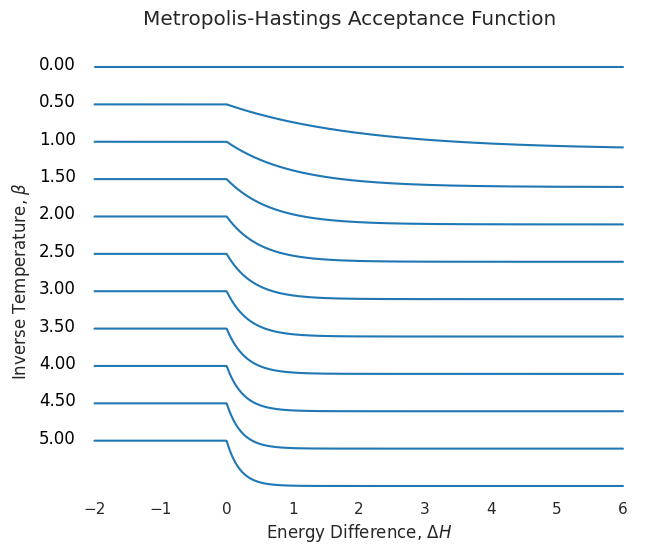

In [11]:
# Prepare data
beta = np.linspace(0, 5, 11)
delta = np.linspace(-2, 6, 1000)

df = pd.DataFrame(it.product(beta, delta), columns=["beta", "delta"])

def mh_accept(row):
    if row["delta"] < 0:
        return 1.0
    return np.exp(-row["beta"] * row["delta"])

df["accept"] = df.apply(mh_accept, axis="columns")

# Plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(df, row="beta", hue="beta", aspect=15, height=.5)

g.map(sns.lineplot, "delta", "accept", clip_on=False,
      alpha=1, linewidth=1.5, color="tab:blue")

def label(x, color, label):
    label = f"{float(label):.2f}"
    ax = plt.gca()
    ax.text(-0.05, 1.0, label, color="black",
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "beta")
g.figure.subplots_adjust(hspace=-.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.suptitle("Metropolis-Hastings Acceptance Function")
plt.title("Inverse Temperature, $β$", rotation=90, ha="left", va="center", x=-0.1, y=4.0)
plt.xlabel("Energy Difference, $ΔH$")



##### Glauber Algorithm

The Glauber algorithm follows the same steps as the Metropolis-Hastings algorithm except
with a slightly different acceptance criterion: 

$$
𝒜_{G, i → t} = \frac{1}{1 + \exp(β Δ𝒣_{i→t})}
$$

Variations of these algorithms exist and they are sometimes implemented as _checkerboard_ algorithms to improve the computational efficiency of them (Yang et al., 2019).

Notably the Metropolis-Hastings and the Glauber algorithm have high _rejection_ rates 

#### Cluster Algorithms

In order to mitigate against the adverse effects on the correlation time through configurations with large correlation lengths, $ξ$, we may employ the use of _cluster algorithms_. They get around this problem by working with whole clusters of like spins rather than a single spin at a time.

These are generally preferred over local algorithms and are not much more complicated to implement in most cases. If we weren't concerned about performance and didn't have the many extra constraints imposed by running in JAX and on GPU/TPU hardware, we could get away with a solution like the one outline on (Timothy Budd, n.d.).

##### Wolff Algorithm
In order to aid the reader's appreciation of JAX and why running software directly on a device such as the TPU is non-trivial, we will go over the implementation of the popular _Wolff algorithm_ in JAX and Equinox here. The actual implementation can be found in `jackpot/algorithms/cluster.py` and `jackpot/algorithms/wolff.py`.

In addition to (Timothy Budd, n.d.), (deLyra, 2006) proved a valuable introduction to the Wolff algorithm.

For visualisation purposes, we will use a $L=4$, $D=2$ system with only two possible spin states. We draw the two spins states either a blue or a red circle.

Next, we connected _neighbouring_ sites with _the same spin state_ together using a link with a probability $P_{link}$:

$$
P_{link} ≡ 1 - \exp(𝒧(J, K, L) β)
$$

Where $𝒧(J, K, L)$ is a the _linkage probability factor_ and determined based on the interaction coefficients between neighbouring spins – not that $𝒧$ is not a function of the environmental interaction coefficients $H$ or $D$.

In many papers the more complicated interaction effects are not considered and we find $𝒧 ≡ - 2J$, taking into consideration factors of 2 depending on the way the model is defined as mentioned previously.

This produces a graph as depicted here, noting the periodic boundary conditions:

![Wolff Spins](images/wolff_spins.png)

Now that we have successfully linked our spins into clusters, we choose a random cluster and "flip" it – or randomise it in the case of more than 2 spin states. We note that the Wolff algorithm is _rejection free_ when defined as it is here. Unfortunately, we also note that it does not take into consideration environmental effects at all. For this reason, we choose to modify it such that we only accept trial clusters with a Metropolis-Hastings-like acceptance function based on the energy change of the transition, which allows us to capture these interactions in the dynamics of our algorithm as well.

Now we are left with the somewhat daunting task of implementing this in JAX in a way that does not involve a mess of `lax` primitives while also emphasising performance.

By staring at the cluster-spin diagram for sufficiently long, we realise that we can produce an array of booleans that hold our links if we copy the shape of the spin array and add a leading axis with a number of elements equal to our dimensionality. That is, we need a link array of shape:
$$
\text{shape(links)} = ( D, \underbrace{L, L, ...}_{D})
$$

We introduce a new Equinox module that holds the data associated with our _cluster solution_. It proved necessary to have a few attempts at an implementation before finding one that was sufficiently aesthetically pleasing and, crucially, works.

In [12]:
# Taken directly from `jackpot/algorithms/cluster.py`
class ClusterSolution(eqx.Module):
    """
    A traditional cluster solver found in many Wolff and Swendsen-Wang papers
    does not work within a JAX context as the shape of neighbours in a cluster
    cannot be known at compile time and thus cannot be probed using array
    programming approaches.

    This forces us to come up with a fully vectorised clustering solution,
    which incidentally is also very efficient.

    While the code below looks tiny, it took an awfully long time to come
    up with this solution after trying less vectorised versions that relied
    on a large number of LAX primitives.

    Additionally this solves the problem of multiple visits which many iterative
    approaches neglect. If not mitigated against, this leads to linking rates
    that are too high, especially in higher dimensional spaces.
    """

    rng_key: RNGKey
    links: Bool[Array, "ndim *dims"]

    @classmethod
    @eqx.filter_jit
    def clusterise_state(cls, rng_key: RNGKey, state: State) -> Self:
        """
        This runs our clustering algorithm (not cluster algorithm) on a state
        and returns a ClusterSolution.
        """
        spins = state.spins
        shape = spins.shape

        # Construct an array where the first axis holds the different layers
        # Each layer corresponds to neighbours along a particular dimensional axis
        neighbours = jnp.empty((spins.ndim, *shape), dtype=spins.dtype)
        for i in range(spins.ndim):
            neighbours = neighbours.at[i].set(jnp.roll(spins, shift=-1, axis=i))

        # Compute a link factor for each neighbour site
        link_factors = state.model.get_cluster_linkage_factors(
            state=state, spins=spins, neighbours=neighbours
        )

        # Threshold value that our random number must be below for us to
        # establish a link
        link_thresholds = 1.0 - jnp.exp(link_factors)

        # Generate a random number for each site.
        # In Wolff algorithm where only a single cluster is flipped it might
        # seem a bit excessive to generate this many numbers since PRNG generation
        # is expensive.
        # It has to be done this way though as the number of sites in a cluster
        # cannot be known and we require known shapes at compile time
        # Generating unused keys is a small price compared to the efficiency of
        # doing the clustering in a vectorised manner.
        randoms = random.uniform(key=rng_key, shape=link_thresholds.shape)

        # Establish all links
        # After this, our spin-link graph is fully computed
        # Selecting the generated clusters is a difficult problem in its own
        # right in a vectorised context. This responsibility is given to
        # the ClusterSelection class.
        links = link_thresholds > randoms

        return ClusterSolution(rng_key=rng_key, links=links)

![Wolff.Spins](images/wolff_spins.png)

We want to try out our fancy new algorithm on a system, so let's make one and learn a little about the design of the jackpot library developed as part of this project.

We need a physical model. The model is a class that must implement the possible spin
states and have methods that return the Hamiltonian of a state, the energy change
of a state given a transition, and the linkage factors used in our cluster solution.
Notably the model class is entirely decoupled from the algorithm implementation
and implementing new models is quite simple. Let's build an Ising Model:

In [13]:
model = IsingModel.new(
    spin=0.5,  # ⇒ Possible spin states: -0.5, +0.5
    interaction_bilinear=1.0,  # J
    interaction_biquadratic=0.0, # K
    interaction_anisotropy=0.0, # D
    interaction_bicubic=0.0,  # L
    interaction_external_field=0.0, # H
    nuclear_magnetic_moment=1.0, # μ
)

Next we need to get a `State` object. A state is effective a _configuration_ or _sample_ as defined in the sections covering Monte Carlo algorithms and the thermodynamic foundations of the project. Notably the state object also implements some convenient logic, but is nothing more than a `PyTree` with some methods attached – these methods can naturally only take the instantiated object as an input and must manifest any modifications to the state by returning a new state, as we are subject to the requirement that all JAX functions must be pure and thus cannot modify the state mutably.

The state, in addition to just the spin configuration on the lattice, also holds an `id` value, a count of how many algorithmic steps or sweeps it has undergone, the inverse temperature of the state, and the lattice algorithm and model associated with the state.

This is captured in the beginning of the definition of `State`:
```python
class State(EnsamblableModule):
    """
    Represents an (immutable) state of the system.

    This object should contain all information about the system,
    how to measure the system and how to evolve the state.
    """

    spins: TSpins
    beta: Float[Array, ""]

    model: Model
    algorithm: Algorithm

    id_: int
    steps: int = 0
    sweeps: int = 0
    ...
```

Let's make a new state from a random distribution. To do that, we need some randomness. While inside of a JAX-context we cannot conjure up any randomness, we don't suffer that restriction when inside a regular Python context. `EasyKey` is simply a neat class that makes it easy to get a fresh RNG key for JAX.

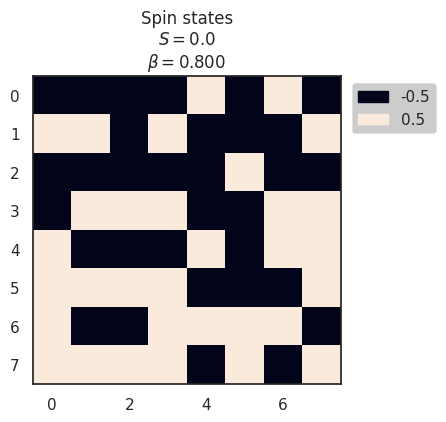

In [14]:
# We can easily get RNG keys from EasyKey
k = EasyKey(seed=1234) # k.new → gives a new RNG key and mutates the EasyKey instance

# We need to pass in an Algorithm object as well, but we won't use that for now.
# We will pass in a Glauber algorithm, but we won't use it here
glauber_alg = GlauberAlgorithm()

state = State.new_uniform_random(
    rng_key=k.new,
    dimensions=2,
    size=8,
    beta=0.8,
    model=model,
    algorithm=glauber_alg,
    id_=0
)

state.plot();

We can now demonstrate that our clustering algorithm works

In [15]:
cluster_solution = ClusterSolution.clusterise_state(rng_key=k.new, state=state)
cluster_solution.links.astype(int)

Array([[[0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 1],
        [1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]]], dtype=int32)

While the links of the cluster could arguably be presented more nicely, each `1` of the array marks a single link between two neighbouring states. We can also see that we have two layers of links, one corresponding to the horizontal dimension and one corresponding to the vertical dimension. In the figure with the spin-link diagram, these links are more clearly indicated through two differently coloured bars denoting a formed link and two differently filled dots denoting an unformed link.

We now face a problem that might seem trivial, but having constructed our clusters, how do we flip a single cluster? This, within the confines of JAX, is surprisingly non-trivial. Initially the clustering and cluster selection algorithms were implemented in a single function and a single site was selected and links grown iteratively in a similar manner to what most implementations in the literature do. That begs the question, however, how many random keys do we need? We cannot run out, but JAX requires that we know our memory layout ahead of time, so we would need to generate all the keys up front or alternatively split and returns keys for each iteration. More importantly, how do we store our links? In regular Python an obvious (albeit impossible to vectorise) approach to this would be to store our link indices in a list that we append to. But JAX again requires the list to have a known size at compile time, and we would thus need a list with as many elements as we have in the link array above nonetheless.

Instead we will implement a separate cluster selection class where we have a boolean mask that denotes which spins are _selected_ and iteratively grow a seed site using the links we found above. The reason these two algorithms are located in separate classes is that the `ClusterSelection` objects are in fact the immutable states we transition over during our iterations.



In [16]:
# Taken from `jackpot/algorithms/cluster.py`
class ClusterSelection(eqx.Module):
    selected: Bool[Array, "*dims"]
    cluster_solution: ClusterSolution
    is_done: bool
    steps: int
    """
    Marks a single selected cluster.

    This is done by iteratively following and marking sites from an initial
    seed site via the links obtained in the cluster solution.

    Together `cluster_solution.links` and `selected` make up a graph of spin
    sites and interconnecting links.

    This process is fundamentally unparallelisable and cannot be vectorised
    further than what is done below (after for loop is unrolled at compile time).

    Attributes:
        selected: Array of bools masking which spin sites are part of this
            specific cluster.
        cluster_solution: A solution from the clustering routine.
            This object holds the probabilistically determined links
        is_done: boolean flag demarking whether cluster selection has terminated
        steps: number of steps it has taken to find cluster from seed index
        """

    @classmethod
    @eqx.filter_jit
    def new(
        cls, selected: Bool[Array, "*dims"], cluster_solution: ClusterSolution
    ) -> Self:
        return cls(
            selected=selected,
            cluster_solution=cluster_solution,
            is_done=False,
            steps=0,
        )

    @classmethod
    @eqx.filter_jit
    def from_seed_idx(
        cls, cluster_solution: ClusterSolution, seed_idx: UInt[Array, "a"]
    ) -> Self:
        """
        Find a full selection from a single seed site.

        Uses a un-unrollable while-loop underneath.
        """
        spins_shape = cluster_solution.links.shape[1:]
        selected = jnp.zeros(shape=spins_shape, dtype=bool)
        selected = selected.at[tuple(seed_idx)].set(True)

        selector = cls.new(selected=selected, cluster_solution=cluster_solution)
        selector = lax.while_loop(
            selector.should_continue, selector.expand_selection_step, selector
        )

        return selector

    @staticmethod
    @eqx.filter_jit
    def should_continue(cluster_selector: ClusterSelection) -> bool:
        """
        Used as part of the LAX `while_loop` to determine whether to exit loop.
        """
        return cluster_selector.is_done == False  # noqa: E712

    @staticmethod
    @eqx.filter_jit
    def expand_selection_step(cluster_selector: ClusterSelection) -> ClusterSelection:
        """
        A single step that expands our cluster selection by following the
        edges in our spin-link graph.
        """
        selector = cluster_selector
        solution = cluster_selector.cluster_solution
        # Holds all selected sites this round
        selected = selector.selected

        # This can be possibly be done with broadcasting,
        # but since we JIT anyway we prefer a more readable version.
        # Since selection shape is known at compile time this 
        # embarrasingly paralllel loop gets unrolled trivially by XLA.
        for i in range(selector.selected.ndim):
            # i denotes the 'layer', where each layer corresponds to
            # links along a particular axis.
            # In 3D: [0] is the up-down axis, [1] is left-right, [2] is in-out
            # Below we use up/down notation for all axis though

            # All links connected to selected sites
            links_to_try = selector.selected | jnp.roll(selector.selected, -1, i)

            # Filter: only the links we have activated
            links_selected = links_to_try & solution.links[i]

            # Expand selected links since links are bidirectional
            links_selected = links_selected | jnp.roll(links_selected, 1, i)

            # Add newly selected sites
            selected = selected | links_selected

        # The sites that changed since last iteration
        new_sites = selected ^ selector.selected
        is_done = new_sites.sum() == 0

        return ClusterSelection(
            selected=selected,
            cluster_solution=solution,
            is_done=is_done,
            steps=selector.steps + 1,
        )

We apply this to select a single cluster in our state:

In [17]:
seed_idx = (0, 2)
selection = ClusterSelection.from_seed_idx(cluster_solution=cluster_solution, seed_idx=seed_idx)

In [18]:
# For demonstration purposes, let's try to modify a JAX array:
plot_selection = selection.selected.astype(int)
plot_selection[seed_idx] = 2

# This is intended to raise an error.

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

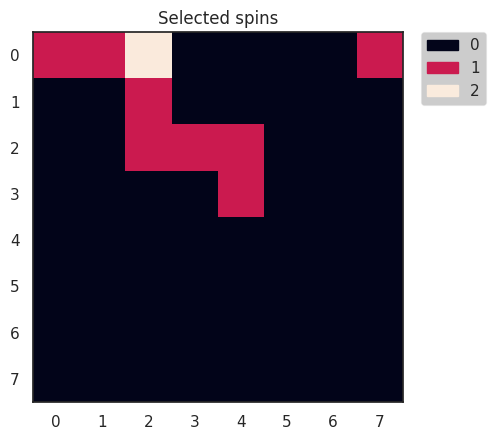

In [ ]:
# Bring the array back to the host and store it in a more agreeable numpy array
plot_selection = np.asarray(selection.selected).astype(int)
plot_selection[seed_idx] = 2
show(plot_selection, "Selected spins")

We can now use this selection to easily implement the Wolff algorithm

In [19]:
# Taken from `jackpot/algorithms/wolff.py`
class DemonstrationWolffAlgorithm(ClusterAlgorithm):
    """
    Implementation of the Wolff algorithm.

    Notably features support for the Metropolis-Hastings-like acceptance
    modification used to enable working with systems that interact with the
    environment. This could, for example, be an external magnetic field or
    some other spin-lattice interaction that cannot be wrapped up in the
    clustering step.
    """

    def step(self, rng_key: RNGKey, state: State) -> State:
        raise NotImplementedError("Wolff is a cluster algorithm and can only sweep")

    def sweep(self, rng_key: RNGKey, state: State) -> State:
        point_key, spin_key, accept_key = random.split(key=rng_key, num=3)

        # First step is solving for the clusters
        solution = ClusterSolution.clusterise_state(rng_key=rng_key, state=state)

        # Next we find a cluster and select it
        seed_idx = get_random_point_idx(rng_key=point_key, shape=state.shape)
        current_spin = state.spins[tuple(seed_idx)]

        selection = ClusterSelection.from_seed_idx(
            cluster_solution=solution, seed_idx=seed_idx
        )

        # Set the cluster to our a new spin on our trial state
        trial_spin = get_trial_spin(
            rng_key=spin_key, state=state, current_spin=current_spin
        )
        trial_spins = jnp.where(selection.selected, trial_spin, state.spins)

        # Note: we cannot mutate PyTree, so we use Equinox convenience method
        # to produce a new tree with the changes we want
        where = lambda s: s.spins
        trial_state = eqx.tree_at(where, state, trial_spins)

        # Update number of steps taken
        new_steps = selection.selected.sum()
        where = lambda s: s.steps
        trial_state = eqx.tree_at(where, trial_state, trial_state.steps + new_steps)

        # Probabilistically select trial state
        # This is a standard technique when using external field or anisotropy
        # interactions.
        # It essentially adds a Metropolis-Hastings like transition probability
        # to the cluster update, which enables these dynamics in a way that
        # cannot be accomplished using link dynamics.
        if self.probabilistic_cluster_accept:
            delta_H = state.model.get_hamiltonian(
                trial_state
            ) - state.model.get_hamiltonian(state)
            accept = metropolis_hastings_accept(
                rng_key=accept_key, beta=state.beta, delta=delta_H
            )

            new_state = lax.cond(accept, lambda: trial_state, lambda: state)

        else:
            new_state = trial_state

        return new_state


Having now implemented an algorithm suitable for use in the `jackpot` framework save for a few utility functions, we can now give our Wolff algorithm a try:

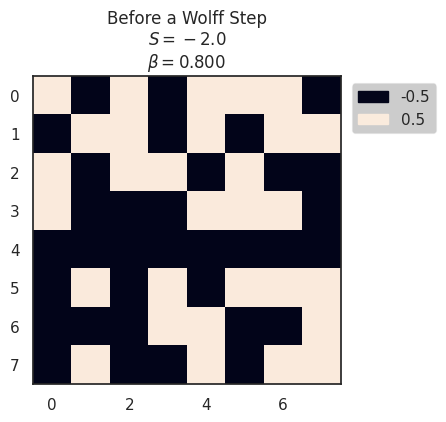

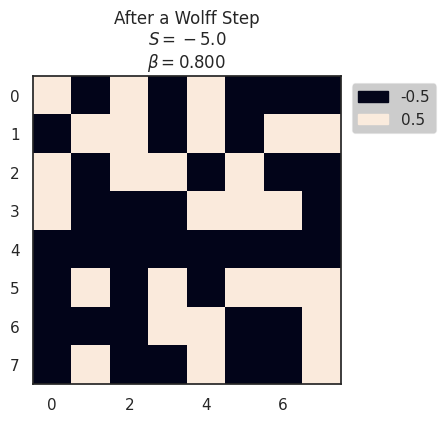

In [25]:
demo_wolff_algorithm = DemonstrationWolffAlgorithm(probabilistic_cluster_accept=False)

# Let's make a new state where we use the algorithm we just made!
state = State.new_uniform_random(
    rng_key=k.new,
    dimensions=2,
    size=8,
    beta=0.8,
    model=model,
    algorithm=demo_wolff_algorithm,
    id_=0
)

state.plot(title="Before a Wolff Step");
state = state.evolve_sweeps(k.new, sweeps=1)
state.plot(title="After a Wolff Step");

While admittedly could not 

## Acknowledgements
I wish to thank Google for providing generous access to free `TPU v2-8` and `TPU v3-8` machines through their TPU Research Cloud (TRC, Google, n.d.) programme.

## References
- van der Maas, H.L.J., Dalege, J., Waldorp, L., 2020. The polarization within and across individuals: the hierarchical Ising opinion model. Journal of Complex Networks 8, cnaa010. https://doi.org/10.1093/comnet/cnaa010
- XLA, Google, n.d. XLA: Optimizing Compiler for Machine Learning [WWW Document]. TensorFlow. URL https://www.tensorflow.org/xla (accessed 4.21.23).
- TPU, Google, n.d. Train and run machine learning models faster | Cloud TPU [WWW Document]. Google Cloud. URL https://cloud.google.com/tpu (accessed 4.21.23).
- TRC, Google, n.d. TPU Research Cloud - About [WWW Document]. URL https://sites.research.google/trc/about/ (accessed 4.21.23).
- Taheridehkordi, A., Zivieri, R., 2020. Critical behavior of the classical spin-1 Ising model: a combined low-temperature series expansion and Metropolis Monte Carlo analysis. arXiv:2007.08593 [cond-mat].
- Strecka, J., Jaščur, M., 2015. A brief account of the Ising and Ising-like models: Mean-field, effective-field and exact results 65.
- Selke, W., 2006. Critical Binder cumulant of two-dimensional Ising models. Eur. Phys. J. B 51, 223–228. https://doi.org/10.1140/epjb/e2006-00209-7
- Timothy Budd, n.d. 6. Criticality & Cluster algorithms — Monte Carlo Techniques [WWW Document]. URL https://hef.ru.nl/~tbudd/mct/lectures/cluster_algorithms.html (accessed 4.23.23).
- Lundow, P.H., Campbell, I.A., 2018. Hyperscaling breakdown and Ising spin glasses: The Binder cumulant. Physica A: Statistical Mechanics and its Applications 492, 1838–1852. https://doi.org/10.1016/j.physa.2017.11.101
- Kidger, P., Garcia, C., 2021. Equinox: neural networks in JAX via callable PyTrees and filtered transformations. https://doi.org/10.48550/arXiv.2111.00254
- Yang, K., Chen, Y.-F., Roumpos, G., Colby, C., Anderson, J., 2019. High Performance Monte Carlo Simulation of Ising Model on TPU Clusters. https://doi.org/10.48550/arXiv.1903.11714
- deLyra, J.L., 2006. The Wolff Algorithm with External Sources and Boundaries.





